## <font color = 'purple'>Notebook 6: Support Vector Machine (SVM)</font>

<font color = 'purple'>SVM is effective for sentiment analysis and feedback categorisation because it excels at handling high-dimensional data, such as text converted into TF-IDF features, and can create a clear decision boundary between classes like positive and negative sentiment. Its ability to work well with small to medium-sized datasets and avoid overfitting makes it a strong choice for tasks like categorising digital product feedback.</font>

## <font color = 'purple'>Import packages</font>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving main_dataset.xlsx to main_dataset.xlsx


In [ ]:
# Libraries for data processing
import numpy as np
import pandas as pd

# Libraries for text processing and NLP
import nltk
from textblob import TextBlob

# Gensim library for topic modelling and text vectorisation
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess

# Libraries for data visualisation
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import matplotlib.pyplot as plt

# Miscellaneous imports
import re
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#pip install --upgrade numexpr bottleneck

In [ ]:
# Verifying installation of dependencies
import numexpr
import bottleneck

print("NumExpr version:", numexpr.__version__)
print("Bottleneck version:", bottleneck.__version__)

NumExpr version: 2.10.1
Bottleneck version: 1.4.1


## <font color = 'purple'>Load data</font>
<font color = 'purple'>Note: Due to a TrueType fonts error appearing during WordCloud process, which occurred due to the combined_reviews.csv file containing a different font, this had to be changed to Arial for the error to be diminished.</font>

In [ ]:
df = pd.read_excel('main_dataset.xlsx')

print("Shape of the dataset:", df.shape)
print("Columns in the dataset:", df.columns)

df.head()

Shape of the dataset: (44855, 4)
Columns in the dataset: Index(['date', 'review', 'rating', 'userName'], dtype='object')


,date,review,rating,userName
0,2021-05-06 05:15:00.000,This feature has been one of the most annoying...,5,Keanu De Sousa
1,2024-02-01 09:06:59.904,"The privacy on WhatsApp is incredible, I know ...",4,The great idea!!!
2,2023-08-14 05:42:00.000,"Hi WhatsApp,\nThis app is really great, I use ...",4,Pokey Ball ‚öæÔ∏è
3,2024-08-04 15:53:00.384,If there was ever an equivalent of social serv...,1,Zenicero
4,2024-05-26 01:12:59.616,Im on holiday and reliant on whatsapp to commu...,1,JohnDoe63737286


In [ ]:
#pip install --upgrade openpyxl

In [ ]:
import openpyxl
print(openpyxl.__version__)

3.1.5


### <font color = 'purple'>Data Pre-processing</font>



<font color = 'purple'>
The below code defines a `preprocess_text` function to clean and standardise text by converting it to lowercase, removing punctuation, digits, and extra spaces. It applies this function to the 'content' column of a DataFrame, creating a new column `content_cleaned` with the processed text.
</font>

In [ ]:
import nltk
from nltk.corpus import stopwords

# Download stopwords if you haven't already
nltk.download('stopwords')

# Set of stopwords in English
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if pd.isna(text) or not isinstance(text, str):
        return ""

    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Split text into words and remove stopwords
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]

    # Join the filtered words back into a single string
    cleaned_text = ' '.join(filtered_words)

    return cleaned_text

df['content_cleaned'] = df['review'].apply(preprocess_text)
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,date,review,rating,userName,content_cleaned
0,2021-05-06 05:15:00.000,This feature has been one of the most annoying...,5,Keanu De Sousa,feature one annoying aspects whatsapp everytim...
1,2024-02-01 09:06:59.904,"The privacy on WhatsApp is incredible, I know ...",4,The great idea!!!,privacy whatsapp incredible know probably donä...
2,2023-08-14 05:42:00.000,"Hi WhatsApp,\nThis app is really great, I use ...",4,Pokey Ball ‚öæÔ∏è,hi whatsapp app really great use everyday exac...
3,2024-08-04 15:53:00.384,If there was ever an equivalent of social serv...,1,Zenicero,ever equivalent social services took words awa...
4,2024-05-26 01:12:59.616,Im on holiday and reliant on whatsapp to commu...,1,JohnDoe63737286,im holiday reliant whatsapp communicate agents...


In [ ]:
df.isnull()
total_null_values = df.isnull().sum().sum()
print("Total null values in the DataFrame: ", total_null_values)

Total null values in the DataFrame:  12


In [ ]:
df.fillna('', inplace = True)

In [ ]:
df['date'] = pd.to_datetime(df['date'], dayfirst = True)

In [ ]:
df = df[['content_cleaned', 'review', 'rating', 'date']]
df.head()

,content_cleaned,review,rating,date
0,feature one annoying aspects whatsapp everytim...,This feature has been one of the most annoying...,5,2021-05-06 05:15:00.000
1,privacy whatsapp incredible know probably donä...,"The privacy on WhatsApp is incredible, I know ...",4,2024-02-01 09:06:59.904
2,hi whatsapp app really great use everyday exac...,"Hi WhatsApp,\nThis app is really great, I use ...",4,2023-08-14 05:42:00.000
3,ever equivalent social services took words awa...,If there was ever an equivalent of social serv...,1,2024-08-04 15:53:00.384
4,im holiday reliant whatsapp communicate agents...,Im on holiday and reliant on whatsapp to commu...,1,2024-05-26 01:12:59.616


In [ ]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

In [ ]:
df['sentiment'] = df['content_cleaned'].apply(get_sentiment)
df['sentiment_label'] = df['sentiment'].apply(lambda x: 'positive' if x > 0.1 else
                                             ('negative' if x <- 0.1 else 'neutral'))

In [ ]:
df[['content_cleaned', 'rating', 'sentiment_label']]

,content_cleaned,rating,sentiment_label
0,feature one annoying aspects whatsapp everytim...,5,negative
1,privacy whatsapp incredible know probably donä...,4,positive
2,hi whatsapp app really great use everyday exac...,4,positive
3,ever equivalent social services took words awa...,1,positive
4,im holiday reliant whatsapp communicate agents...,1,negative
...,...,...,...
44850,free delivery prime,5,positive
44851,would expectamazon trying get hand pocket,3,neutral
44852,registry system mess sorting price low high wa...,2,neutral
44853,clothes furniture options kinda meh overall de...,3,neutral


In [ ]:
# Libraries for model building and evaluation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.svm import SVC

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features = 5000)
X = tfidf_vectorizer.fit_transform(df['content_cleaned'])
y = df['sentiment_label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("-" * 60)

In [ ]:
# Train the SVM classifier
svm_model = SVC(kernel = 'linear')
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

Accuracy Score: 0.9372422249470516

Confusion Matrix:
 [[ 553  149    6]
 [  61 3142  128]
 [   3  216 4713]]

Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.78      0.83       708
     neutral       0.90      0.94      0.92      3331
    positive       0.97      0.96      0.96      4932

    accuracy                           0.94      8971
   macro avg       0.92      0.89      0.91      8971
weighted avg       0.94      0.94      0.94      8971



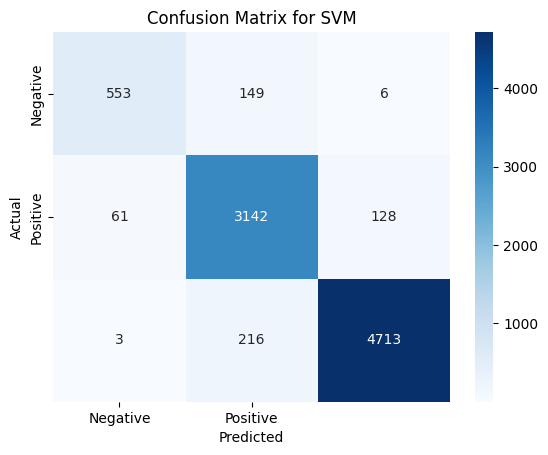

In [ ]:
y_pred = svm_model.predict(X_test)

print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = ['Negative', 'Positive'], yticklabels = ['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for SVM')
plt.show()

In [ ]:
def evaluate_svm(kernel_type):
    svm_model = SVC(kernel = kernel_type)
    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_test)

    print(f"Evaluation for {kernel_type} kernel:")
    print("Accuracy Score:", accuracy_score(y_test, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("\n" + "-"*50 + "\n")

In [ ]:
# Evaluate different SVM kernels
kernels = ['linear', 'rbf', 'poly', 'sigmoid']

for kernel in kernels:
    evaluate_svm(kernel)

Evaluation for linear kernel:
Accuracy Score: 0.9372422249470516

Confusion Matrix:
 [[ 553  149    6]
 [  61 3142  128]
 [   3  216 4713]]

Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.78      0.83       708
     neutral       0.90      0.94      0.92      3331
    positive       0.97      0.96      0.96      4932

    accuracy                           0.94      8971
   macro avg       0.92      0.89      0.91      8971
weighted avg       0.94      0.94      0.94      8971


--------------------------------------------------

Evaluation for rbf kernel:
Accuracy Score: 0.9493924869022405

Confusion Matrix:
 [[ 559  144    5]
 [  28 3223   80]
 [   1  196 4735]]

Classification Report:
               precision    recall  f1-score   support

    negative       0.95      0.79      0.86       708
     neutral       0.90      0.97      0.94      3331
    positive       0.98      0.96      0.97      4932

    accuracy         

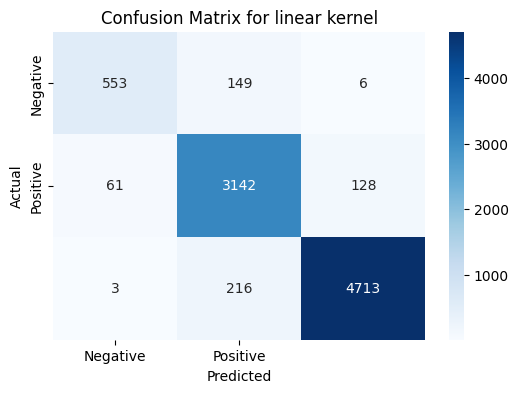

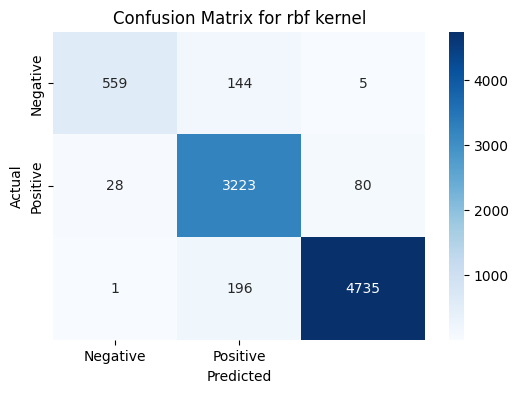

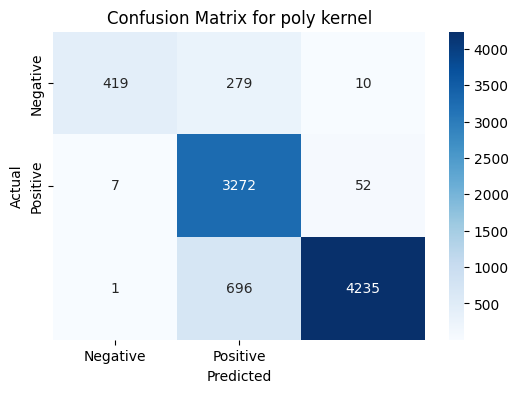

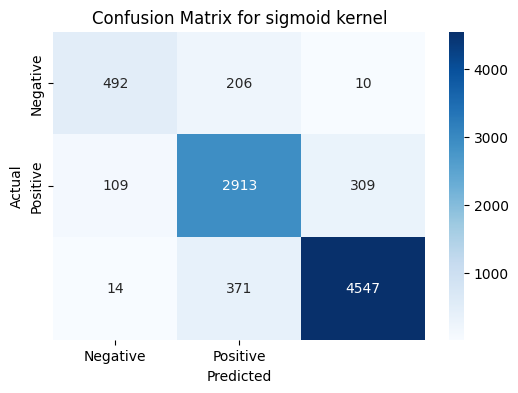

In [ ]:
# Visualise the confusion matrices for each kernel
def plot_confusion_matrix(kernel_type):
    svm_model = SVC(kernel = kernel_type)
    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_test)

    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = (6, 4))
    sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = ['Negative', 'Positive'], yticklabels = ['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {kernel_type} kernel')
    plt.show()

# Plot confusion matrices for each kernel
for kernel in kernels:
    plot_confusion_matrix(kernel)

In [ ]:
# GridSearch library
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], # Different kernels
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]
}

In [ ]:
# Initialise the SVM model
svm_model = SVC()

grid_search = GridSearchCV(estimator = svm_model, param_grid = param_grid,
                           scoring = 'accuracy', cv = 5, verbose = 2, n_jobs = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=  58.5s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=  59.0s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=  57.6s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=  58.1s
[CV] END ........C=0.1, degree=2, gamma=scale, kernel=linear; total time=  57.5s
[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time= 1.3min
[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time= 1.3min
[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time= 1.3min
[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time= 1.4min
[CV] END ...........C=0.1, degree=2, gamma=scale, kernel=rbf; total time= 1.4min
[CV] END ..........C=0.1, degree=2, gamma=scale, kernel=poly; total time= 1.6min
[CV] END ..........C=0.1, degree=2, gamma=scale

<font color = 'purple'>Due to GPU and memory limitations, the Hyperparameter Tuning for SVM has been omitted.</font>

In [ ]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Accuracy: {:.2f}%".format(best_score * 100))

In [ ]:
# Train the model with the best parameters
best_svm_model = grid_search.best_estimator_
best_svm_model.fit(X_train, y_train)

# Evaluate the tuned model on the test set
y_pred = best_svm_model.predict(X_test)

print("Accuracy Score on Test Set:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plotting the confusion matrix for the tuned model
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Tuned SVM Model')
plt.show()